In [1]:
#loading dependencies - 2020/04/07 - Randy Dettmer 
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, asc, desc

In [4]:
# Create the connection engine 'hawaii.sqlite' database file
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
#create inspector to see column names of classes
inspector = inspect(engine)

In [8]:
#get a list of column names in measurement
mcolumns = inspector.get_columns('measurement')
for c in mcolumns:
    print(c['name'], c['type'])
#columns for measurement

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
#get a list of column names in station
scolumns = inspector.get_columns('station')
for c in scolumns:
    print(c['name'], c['type'])
#columns for station

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Mea = Base.classes.measurement
Sta = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [13]:
# determine latest date in the Measurement (Mea) database
session.query(Mea.date).order_by(Mea.date.desc()).first()

('2017-08-23')

In [14]:
# create variable for last 12 month period of the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=366)
print("Query date:", query_date)

Query date: 2016-08-22


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
data1 = (session.query(Mea.date, Mea.prcp).filter(Mea.date >= query_date).order_by(Mea.date).all())

In [16]:
# create dataframe with only date and prcp with date as index
df1 = pd.DataFrame(data1)
df1.head()

,date,prcp
0,2016-08-22,0.40
1,2016-08-22,0.94
2,2016-08-22,NaN
3,2016-08-22,NaN
4,2016-08-22,0.40


In [17]:
#remove NaN values set index and sort index by date
df2 = df1.dropna(how="any")
df2.set_index('date', inplace=True)
df2.sort_index(ascending=True)
df2.head()

,prcp
date,
2016-08-22,0.40
2016-08-22,0.94
2016-08-22,0.40
2016-08-22,2.32
2016-08-22,1.20


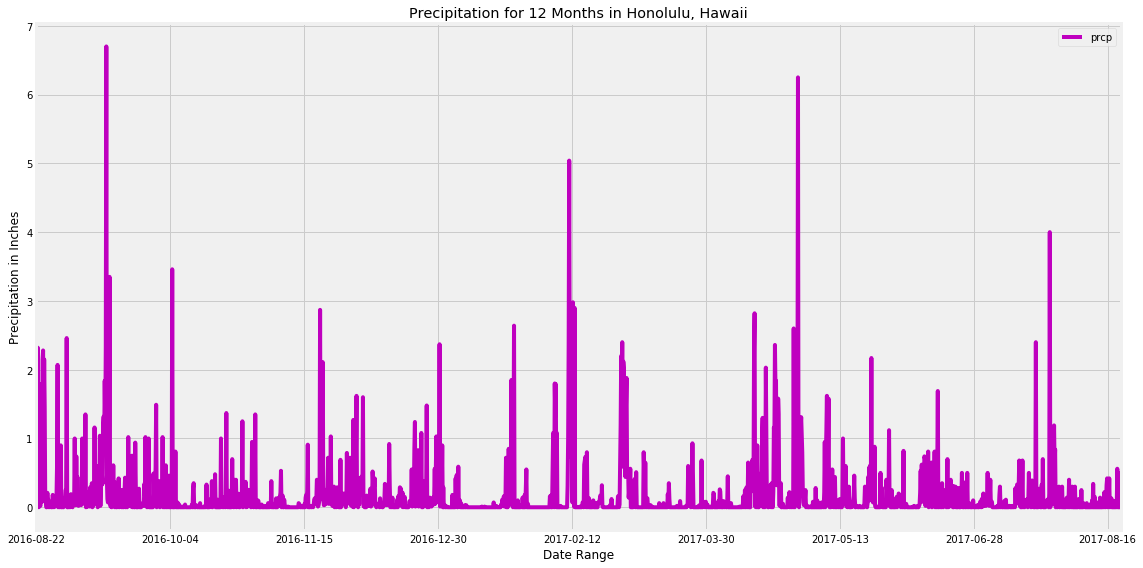

In [18]:
#plot prcp by date
fig, ax = plt.subplots(figsize = (16, 8))
df2.plot(ax = ax, x_compat = True, color='m')

#set title and labels
ax.set_xlabel("Date Range")
ax.set_ylabel("Precipitation in Inches")
ax.set_title("Precipitation for 12 Months in Honolulu, Hawaii")

#save figure
plt.savefig("plot_precp12mo.png")

#plot figure
plt.tight_layout()
plt.show()


In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df2.describe()

,prcp
count,2026.000000
mean,0.179437
std,0.463989
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset
staloc=session.query(Sta).group_by(Sta.station).count()
print(f"Total number of stations in this dataset is {staloc}.")

Total number of stations in this dataset is 9.


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)
# List the stations and the counts in descending order.
stacnt = (session.query(Mea.station, func.count(Mea.station)).group_by(Mea.station).order_by(func.count(Mea.station).desc()).all())
#print list of activity of stations
stacnt

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
mactsta = (session.query(Mea.station, func.count(Mea.station)).group_by(Mea.station).order_by(func.count(Mea.station).desc()).first())
print(f"The most active station was {mactsta[0]} with {mactsta[1]} recordings.")

The most active station was USC00519281 with 2772 recordings.


In [23]:
# collect temperature data for most active station
macttemp =session.query(func.min(Mea.tobs), func.max(Mea.tobs), func.avg(Mea.tobs)).filter(Mea.station==mactsta[0]).all()
print(f"The lowest temperature recorded at {mactsta[0]} is: {macttemp[0][0]} degrees Fahrenheit.")
print(f"The highest temperature recorded at {mactsta[0]} is: {macttemp[0][1]} degrees Fahrenheit.")
print(f"The average temperature recorded at {mactsta[0]} is: {round(macttemp[0][2], 1)} degrees Fahrenheit.")

The lowest temperature recorded at USC00519281 is: 54.0 degrees Fahrenheit.
The highest temperature recorded at USC00519281 is: 85.0 degrees Fahrenheit.
The average temperature recorded at USC00519281 is: 71.7 degrees Fahrenheit.


In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# query for the last year of temperature data for one year
tdata = (session.query(Mea.date, Mea.tobs).filter(Mea.date >= query_date).filter(Mea.station == mactsta[0]).order_by(Mea.date).all())

In [25]:
#convert query object to data frame
df3 = pd.DataFrame(tdata)
df3 = df3.set_index("date")

#sort by date
df3 = df3.sort_index(ascending=True)

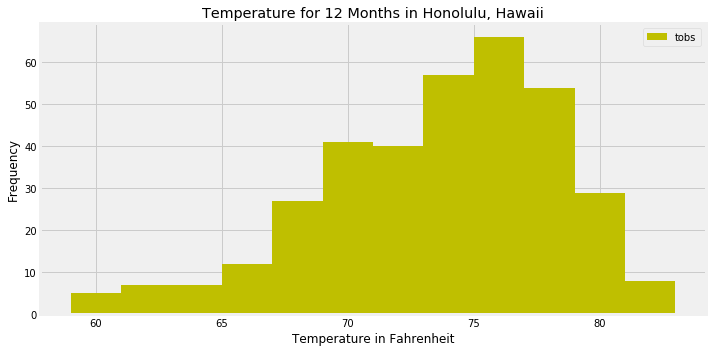

In [26]:
#plot histogram
fig, ax = plt.subplots(figsize=(10,5))
df3.plot.hist(bins = 12, ax = ax, color='y')

#set labels
ax.set_xlabel("Temperature in Fahrenheit")
ax.set_ylabel("Frequency")
ax.set_title("Temperature for 12 Months in Honolulu, Hawaii")

#save figure
plt.savefig("plot_temp12mo.png")

#plot figure
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [27]:
# TEMPERATURE ANALYSIS I
#determine if there is a meaningful difference between temperatures between June and December
smon = "06"
emon = "12"

In [28]:
#collect data between June and December for entire data set and put into a dataframe
#data for June
tdataj = session.query(Mea.date, Mea.tobs).\
        filter(func.strftime("%m", Mea.date) == smon).all()
#data for December
tdatad = session.query(Mea.date, Mea.tobs).\
        filter(func.strftime("%m", Mea.date) == emon).all()
#create dataframes for each month
dfj = pd.DataFrame(tdataj)
dfd = pd.DataFrame(tdatad)

dfd.head()

,date,tobs
0,2010-12-01,76.0
1,2010-12-03,74.0
2,2010-12-04,74.0
3,2010-12-06,64.0
4,2010-12-07,64.0


In [29]:
#calculate average temperature for June and December across all years
juneavg = dfj.tobs.mean()
decavg = dfd.tobs.mean()
print(f"The average temperature for June {round(juneavg,1)} degrees Fahrenheit.")
print(f"The average temperature for December {round(decavg,1)} degrees Fahrenheit.")

The average temperature for June 74.9 degrees Fahrenheit.
The average temperature for December 71.0 degrees Fahrenheit.


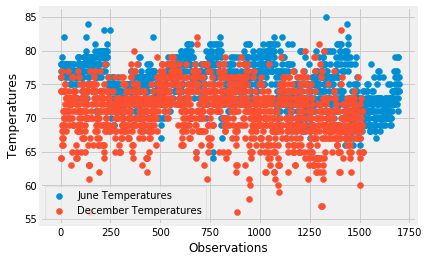

In [30]:
#test means across June and December across all years - t-test
#scatter plot
plt.subplot()
plt.scatter(range(len(dfj.tobs)), dfj.tobs, label="June Temperatures")
plt.scatter(range(len(dfd.tobs)), dfd.tobs, Label="December Temperatures")
plt.xlabel("Observations")
plt.ylabel("Temperatures")
plt.legend()

#save figure
plt.savefig("plot_jundectempscat.png")


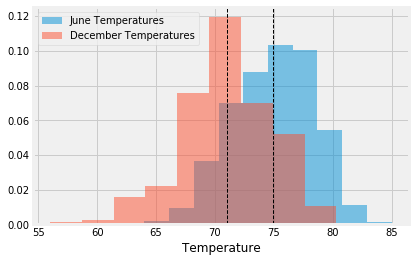

In [31]:
#histogram
plt.subplot()
plt.hist(dfj.tobs, 10, density=True, alpha=0.5, label="June Temperatures")
plt.hist(dfd.tobs, 10, density=True, alpha=0.5, label="December Temperatures")
plt.axvline(dfj.tobs.mean(), color="k", linestyle="dashed", linewidth=1)
plt.axvline(dfd.tobs.mean(), color="k", linestyle="dashed", linewidth=1)
plt.xlabel("Temperature")
plt.legend()

#save figure
plt.savefig("plot_temp12mohist.png")

In [32]:
#load scipy.stats to conduct t-test
import scipy.stats as stats
#Note: setting equal_val=False performs Welch's t-test which does not assume equal population variance
stats.ttest_ind(dfj.tobs, dfd.tobs, equal_var=False)

Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

###Temperature Analysis I - conclusions

#We conduct an independent t-tests comparing the means of 2 independent populations, June and December tobs.
#The test above test measures whether the average (expected) value differs significantly across samples. 
#Since we observe a large p-value of 4.19, then we can reject the null hypothesis of identical average scores.

In [33]:
#TEMPERATURE ANALYSIS II
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Mea.tobs), func.avg(Mea.tobs), func.max(Mea.tobs)).\
        filter(Mea.date >= start_date).filter(Mea.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [34]:
# TEMPERATURE ANALYSIS II
# calculate vacation range - October 7 thru October 14
start_date = dt.date(2016, 10, 7) 
end_date = dt.date(2016, 10, 14)

In [35]:
#calculate year prior date range
yrprior_start = start_date - dt.timedelta(days=366)
yrprior_end = end_date - dt.timedelta(days=366)

print("Query dates:", yrprior_start, yrprior_end)

Query dates: 2015-10-07 2015-10-14


In [36]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax - calculated for year prior with same date range
# for your trip using the previous year's data for those same dates.
#calculate the tmin, tavg, and tmax
pyt = calc_temps(yrprior_start, yrprior_end)
print(f"Trip minimum temperature is: {pyt[0][0]} degrees Fahrenheit.")
print(f"Trip average temperature is: {round (pyt[0][1], 1)} degrees Fahrenheit.")
print(f"Trip maximum temperature is: {pyt[0][2]} degrees Fahrenheit.")


Trip minimum temperature is: 66.0 degrees Fahrenheit.
Trip average temperature is: 75.6 degrees Fahrenheit.
Trip maximum temperature is: 84.0 degrees Fahrenheit.


In [37]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


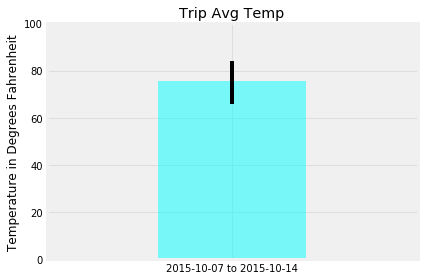

In [38]:
#generate graph with prior year data
tt = calc_temps(yrprior_start, yrprior_end)

mintt = tt[0][0]
avgtt = tt[0][1]
maxtt = tt[0][2]
minerror = avgtt - mintt
maxerror = maxtt - avgtt
errorbars = np.array([[minerror], [maxerror]])

plt.bar("2015-10-07 to 2015-10-14", avgtt, yerr=errorbars, color="aqua", alpha=.5)
plt.ylim(0, 100)
plt.xlim(-1, 1)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature in Degrees Fahrenheit")
plt.grid(alpha=.5)

#save figure
plt.savefig("plot_tripavgtemp.png")

#display figure
plt.tight_layout()
plt.show()

In [39]:
#DAILY RAINFALL AVERAGE
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [40]:
#query for precipitation per station on trip dates using yrprior_start and yrprior_end generated above
sel = ([Sta.station, Sta.name,func.sum(Mea.prcp),Sta.latitude,Sta.longitude,Sta.elevation])

starain = (session.query(*sel).filter(Sta.station == Mea.station).\
    filter(Mea.date >= yrprior_start).filter(Mea.date <= yrprior_end).group_by(Sta.station).order_by(func.sum(Mea.prcp).desc()).all())

#convert query to dataframe
dfr = pd.DataFrame(starain, columns=["Station", "Location", "Precipitation", "Latitude", "Longitude", "Elevation"])

dfr

,Station,Location,Precipitation,Latitude,Longitude,Elevation
0,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",8.63,21.52130,-157.83740,7.0
1,USC00513117,"KANEOHE 838.1, HI US",4.41,21.42340,-157.80150,14.6
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",4.35,21.33556,-157.71139,19.5
3,USC00519281,"WAIHEE 837.5, HI US",3.27,21.45167,-157.84889,32.9
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",1.08,21.33310,-157.80250,152.4
5,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",0.40,21.31520,-157.99920,0.9
6,USC00519397,"WAIKIKI 717.2, HI US",0.12,21.27160,-157.81680,3.0
7,USC00518838,"UPPER WAHIAWA 874.3, HI US",0.00,21.49920,-158.01110,306.6
8,USC00517948,"PEARL CITY, HI US",NaN,21.39340,-157.97510,11.9


In [41]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Mea.tobs), func.avg(Mea.tobs), func.max(Mea.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Mea.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [42]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [43]:
#create a list of trip dates
trip_dates = ["10-07", "10-08", "10-09", "10-10", "10-11", "10-12", "10-13", "10-14"]

In [44]:
#collect list of daily normal temperatures
normals = []

for date in trip_dates:
    day = {}
    day['Date'] = date
    normal = daily_normals(date)
    day['Min'] = normal[0][0]
    day['Avg'] = normal[0][1]
    day['Max'] = normal[0][2]
    normals.append(day)
normals

[{'Date': '10-07', 'Min': 68.0, 'Avg': 75.6078431372549, 'Max': 81.0},
 {'Date': '10-08', 'Min': 66.0, 'Avg': 76.3265306122449, 'Max': 86.0},
 {'Date': '10-09', 'Min': 69.0, 'Avg': 76.11363636363636, 'Max': 84.0},
 {'Date': '10-10', 'Min': 69.0, 'Avg': 75.85416666666667, 'Max': 83.0},
 {'Date': '10-11', 'Min': 69.0, 'Avg': 76.57142857142857, 'Max': 84.0},
 {'Date': '10-12', 'Min': 65.0, 'Avg': 75.75510204081633, 'Max': 82.0},
 {'Date': '10-13', 'Min': 65.0, 'Avg': 75.98039215686275, 'Max': 84.0},
 {'Date': '10-14', 'Min': 67.0, 'Avg': 75.1923076923077, 'Max': 82.0}]

In [45]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
dfn = pd.DataFrame(normals)
#set index
dfn.set_index('Date', inplace = True)
#display
dfn.head()

,Min,Avg,Max
Date,,,
10-07,68.0,75.607843,81.0
10-08,66.0,76.326531,86.0
10-09,69.0,76.113636,84.0
10-10,69.0,75.854167,83.0
10-11,69.0,76.571429,84.0


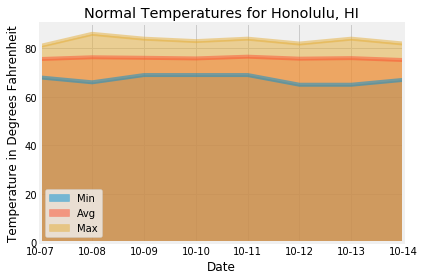

In [46]:
# Plot the daily normals as an area plot with `stacked=False`
dfn.plot.area(stacked=False, alpha=.5)
plt.title("Normal Temperatures for Honolulu, HI")
plt.ylabel("Temperature in Degrees Fahrenheit")

#save figure
plt.savefig("plot_normals.png")

#displat figure
plt.tight_layout()
plt.show()